# **QueryQuik**
## An Intelligent Customer Support Agent

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-google-genai langchain_community langchain_core

In [2]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash' , api_key=gemini_api_key , temprature = 0.2)

In [4]:
from typing_extensions import TypedDict
class State(TypedDict):
  query : str
  category : str
  sentiment : str
  response : str

In [67]:
def Categorize(state:State):
  prompt = '''Categorize this user query into one of these categories: General, Technical, Billings. If the query doesn't fit clearly into any of these, respond with 'General'. Query: {query}'''
  query = state['query']
  category = model.predict(prompt.format(query=query))
  if category == '':
    return {"category": "General"}
  return {"category" : category}

def Sentiment_Analyzer(state:State):
  prompt =   '''Analyze the sentiment of the following customer query.
     Respond with 'Negative' if the person is angry, frustrated, or using strong language.
     Respond with 'Neutral' if the query is neither very positive nor very negative.
     Respond with 'Positive' if the query is positive and friendly. If the sentiment is unclear, respond with 'Negative'.
     Query: {query}'''

  query = state['query']
  sentiment = model.predict(prompt.format(query=query))
  if sentiment == '':
    return {"sentiment" : "Negative"}

  return {"sentiment" : sentiment}
def Escalate (state : State):
  # We will redirect user to a human agent if the sentiment is negative
  return  {"response": "This query has been escalated to a human agent due to its negative sentiment."}
def General_Support(state:State):
  prompt = '''Provide a General Support Response to this query , query : {query} '''
  query = state['query']
  response = model.predict(prompt.format(query=query))
  return {"response" : response}
def Technical_Support(state:State):
  prompt = '''Provide a technical  Support Response to this query , query : {query} '''
  query = state['query']
  response = model.predict(prompt.format(query=query))
  return {"response" : response}
def Billings_Support(state:State):
  prompt = '''Provide a General Support Response to this query , query : {query} '''
  query = state['query']
  response = model.predict(prompt.format(query=query))
  return {"response" : response}
def Decision(state:State):
  sentiment = state['sentiment']
  if sentiment == "Negative" :
    return "Escalate"
  elif state['category'] == 'General' :
    return "General_Support"
  elif state['category'] == 'Technical' :
    return "Technical_Support"
  elif state['category']== 'Billings':
    return "Billings_Support"
  else :
    return "General_Support"


In [68]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

builder = StateGraph(State)
builder.add_node('Categorize' , Categorize)
builder.add_node('Sentiment_Analyzer' , Sentiment_Analyzer)
builder.add_node('Escalate' , Escalate)
builder.add_node('General_Support' , General_Support)
builder.add_node('Technical_Support' , Technical_Support)
builder.add_node('Billings_Support' , Billings_Support)

builder.add_edge(START , 'Categorize')
builder.add_edge('Categorize' , 'Sentiment_Analyzer')
builder.add_conditional_edges('Sentiment_Analyzer' ,Decision ,  {
        "Technical_Support": "Technical_Support",
        "Billings_Support": "Billings_Support",
        "General_Support": "General_Support",
        "Escalate": "Escalate"
    }   )

builder.add_edge("Technical_Support", END)
builder.add_edge("Billings_Support", END)
builder.add_edge("General_Support", END)
builder.add_edge("Escalate", END)

memory = MemorySaver()

agent = builder.compile()



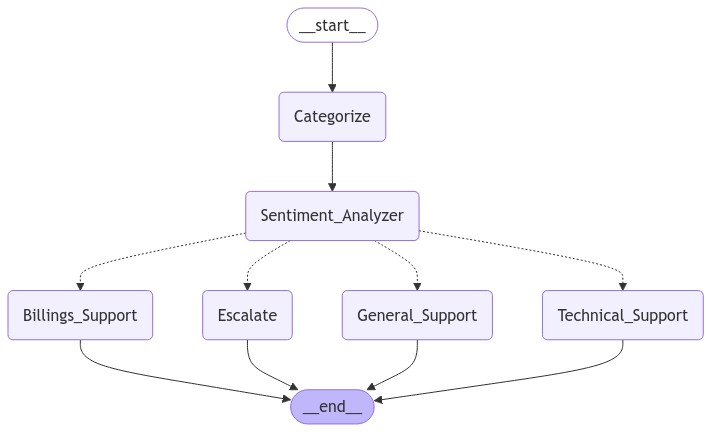

In [69]:
display(Image(agent.get_graph(xray=5).draw_mermaid_png()))

In [78]:
query = "HI ! j  "
result = agent.invoke({"query": query})
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: HI ! can you help me with payment processing   
Category: General 

Sentiment: Neutral 

Response: Hi there! I understand you're looking for help with payment processing. To assist you better, could you please tell me more about what you need help with? For example:

* **What specific payment processing issue are you facing?** (e.g., declined payments, transaction errors, account setup)
* **What platform or service are you using for payment processing?** (e.g., Stripe, PayPal, Shopify)
* **What is the nature of your business or transaction?** (e.g., online store, subscription service, one-time payment)

The more information you provide, the better I can understand your situation and offer relevant assistance. 



